# Tensors and computations

In [1]:
import pickle
import numpy as np
import networkx as nx
import scipy
import matplotlib.pyplot as plt
from itertools import product, permutations
from collections import defaultdict
from copy import copy

import scienceplots

plt.style.use(['science'])

from useful_functions import *
from tensor_functions import *

In [2]:
def centrality_KTs(restricted_hyperedges, m=3):
    
    # Get tensor
    labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)
    T = directed_tensor(relabeled_dictionary, len(labels))
    
    # EC
    EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))
    
    # HEC
    cent, converged = HEC_ours(T, m)
    
    HEC = {}
    for i, c in enumerate(cent):
        HEC[i] = c 
    
    # Save labels 
    ranking = {'labels':labels, 'HEC':HEC, 'EC':EC}
    
    # Compute correlations   
    KendalltopK_HE = []
    for k in range(1, len(HEC)):

        topk1 = topN(HEC, N=k)
        centrals2 = [EC[node] for node in topk1.keys()]

        coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic

        KendalltopK_HE.append(coeff)

    KendalltopK_EH = []
    for k in range(1, len(EC)):

        topk1 = topN(EC, N=k)
        centrals2 = [HEC[node] for node in topk1.keys()]

        coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic

        KendalltopK_EH.append(coeff)
        
    return ranking, KendalltopK_HE, KendalltopK_EH
    

## Chemical reactions

### Astrochem

In [3]:
with open('ProcessedHypergraphs/astrochem2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [4]:
labels, relabeled_dictionary = labels_to_integers(restricted_hyperedges)

In [5]:
T = directed_tensor(relabeled_dictionary, len(labels))

In [6]:
T

({(0, 0, 1): 1,
  (2, 3, 4): 1,
  (3, 2, 4): 1,
  (4, 5, 6): 1,
  (5, 4, 6): 1,
  (4, 5, 3): 1,
  (5, 4, 3): 1,
  (7, 4, 8): 1,
  (4, 7, 8): 1,
  (7, 4, 3): 1,
  (4, 7, 3): 1,
  (4, 9, 0): 1,
  (9, 4, 0): 1,
  (4, 9, 3): 1,
  (9, 4, 3): 1,
  (10, 4, 11): 1,
  (4, 10, 11): 1,
  (10, 4, 3): 1,
  (4, 10, 3): 1,
  (12, 4, 13): 1,
  (4, 12, 13): 1,
  (12, 4, 3): 1,
  (4, 12, 3): 1,
  (14, 4, 15): 1,
  (4, 14, 15): 1,
  (14, 4, 3): 1,
  (4, 14, 3): 1,
  (4, 16, 17): 1,
  (16, 4, 17): 1,
  (4, 16, 3): 1,
  (16, 4, 3): 1,
  (18, 4, 19): 1,
  (4, 18, 19): 1,
  (18, 4, 3): 1,
  (4, 18, 3): 1,
  (4, 20, 21): 1,
  (20, 4, 21): 1,
  (4, 20, 3): 1,
  (20, 4, 3): 1,
  (4, 22, 1): 1,
  (22, 4, 1): 1,
  (4, 22, 0): 1,
  (22, 4, 0): 1,
  (4, 22, 3): 1,
  (22, 4, 3): 1,
  (23, 4, 0): 1,
  (4, 23, 0): 1,
  (23, 4, 24): 1,
  (4, 23, 24): 1,
  (23, 4, 3): 1,
  (4, 23, 3): 1,
  (8, 5, 7): 1,
  (5, 8, 7): 1,
  (8, 5, 6): 1,
  (5, 8, 6): 1,
  (5, 11, 10): 1,
  (11, 5, 10): 1,
  (5, 11, 6): 1,
  (11, 5, 6): 1,


In [7]:
cent, converged = HEC_ours(T, m=3, niter=100000, tol=1e-6, verbose=True)

HEC = {}
for i, c in enumerate(cent):
    HEC[i] = c 

Finished in 10 iterations.


In [8]:
topN(HEC, N=10)

{2: 0.0066275054315635944,
 6: 0.005175876931867682,
 5: 0.005124671498379,
 17: 0.005019238185003913,
 9: 0.004919551533567627,
 13: 0.00475975271461048,
 22: 0.0047588220613814375,
 23: 0.004528496230775676,
 404: 0.00448133647817626,
 407: 0.004398280563061755}

In [9]:
EC = nx.eigenvector_centrality_numpy(standard_network(relabeled_dictionary))

In [10]:
ranking_astro = {'labels':labels, 'HEC':HEC, 'EC':EC}

In [11]:
topN(EC, N=10)

{0: 0.33748719166933955,
 1: 0.2954323390323101,
 24: 0.23737342711203577,
 6: 0.20393682922365172,
 101: 0.19761124153863607,
 17: 0.17547709590841695,
 51: 0.16784940477948324,
 23: 0.13848914450910663,
 19: 0.13022786940901,
 119: 0.11292728218468479}

In [12]:
DC = tensor_in_degree_centrality(T)
topN(DC, N=10)

{0: 3966,
 1: 1755,
 24: 727,
 6: 512,
 17: 383,
 101: 380,
 19: 321,
 51: 316,
 79: 265,
 23: 244}

In [13]:
scipy.stats.kendalltau(list(EC.values()), list(HEC.values())).statistic

0.34720878709395575

In [14]:
KendalltopK_HE = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(HEC, N=k)
    centrals2 = [EC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_HE.append(coeff)

KendalltopK_EH = []
for k in range(1, len(HEC)):
                        
    topk1 = topN(EC, N=k)
    centrals2 = [HEC[node] for node in topk1.keys()]
    
    coeff = scipy.stats.kendalltau(list(topk1.values()), centrals2).statistic
    
    KendalltopK_EH.append(coeff)


In [15]:
KendalltopK_HE_astro = copy(KendalltopK_HE)
KendalltopK_EH_astro = copy(KendalltopK_EH)

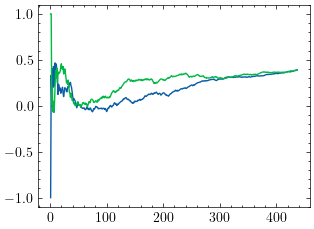

In [16]:
plt.plot(KendalltopK_HE_astro)
plt.plot(KendalltopK_EH_astro)

### KIDA surface

In [17]:
with open('ProcessedHypergraphs/KIDA_surface2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [18]:
ranking_surface, KendalltopK_HE_surface, KendalltopK_EH_surface = centrality_KTs(restricted_hyperedges, m=3) 

Finished in 13 iterations.


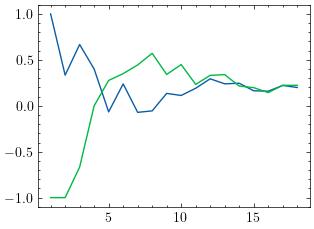

In [19]:
plt.plot(KendalltopK_HE_surface)
plt.plot(KendalltopK_EH_surface)

### KIDA Unibimolecular

In [20]:
with open('ProcessedHypergraphs/KIDA_unibimolecular2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [21]:
ranking_unibi, KendalltopK_HE_unibi, KendalltopK_EH_unibi = centrality_KTs(restricted_hyperedges, m=3) 

Finished in 11 iterations.


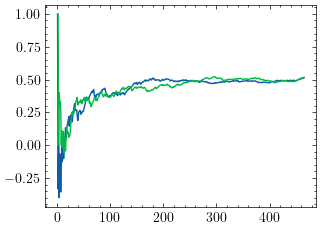

In [22]:
plt.plot(KendalltopK_HE_unibi)
plt.plot(KendalltopK_EH_unibi)

### KIDA uva

In [23]:
with open('ProcessedHypergraphs/KIDA_uva2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [24]:
ranking_uva, KendalltopK_HE_uva, KendalltopK_EH_uva = centrality_KTs(restricted_hyperedges, m=3) 

Finished in 10 iterations.


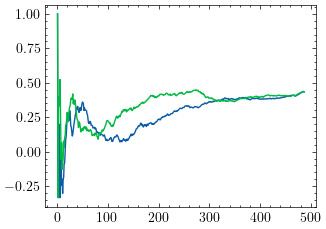

In [25]:
plt.plot(KendalltopK_HE_uva)
plt.plot(KendalltopK_EH_uva)

### Reaction Template Generator

In [26]:
with open('ProcessedHypergraphs/ReactionTemplate2F.pkl', 'rb') as f:
    restricted_hyperedges = pickle.load(f)

In [27]:
ranking_RTG, KendalltopK_HE_RTG, KendalltopK_EH_RTG = centrality_KTs(restricted_hyperedges, m=3) 

Finished in 9 iterations.


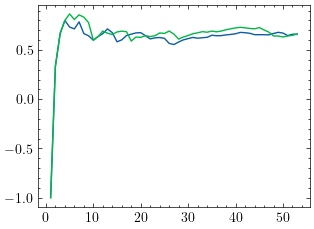

In [28]:
plt.plot(KendalltopK_HE_RTG)
plt.plot(KendalltopK_EH_RTG)

### All together

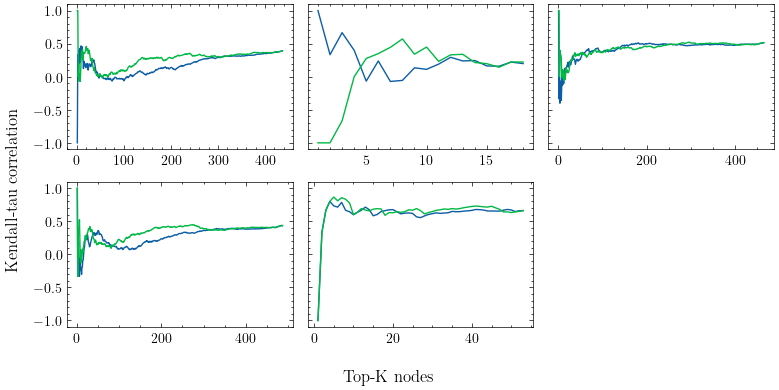

In [29]:
fig, ax = plt.subplots(2,3,figsize=(8,4), sharey=True)

fig.supylabel("Kendall-tau correlation")
fig.supxlabel("Top-K nodes")

ax[0,0].plot(KendalltopK_HE_astro)
ax[0,0].plot(KendalltopK_EH_astro)

ax[0,1].plot(KendalltopK_HE_surface)
ax[0,1].plot(KendalltopK_EH_surface)

ax[0,2].plot(KendalltopK_HE_unibi)
ax[0,2].plot(KendalltopK_EH_unibi)

ax[1,0].plot(KendalltopK_HE_uva)
ax[1,0].plot(KendalltopK_EH_uva)

ax[1,1].plot(KendalltopK_HE_RTG)
ax[1,1].plot(KendalltopK_EH_RTG)

ax[1,2].axis('off')

plt.tight_layout()

plt.savefig("Figures/Kendalltau-TopKs.png")

### Saving all data for later

In [33]:
for name, data in {'astro':ranking_astro, 'surface':ranking_surface, 'unibi':ranking_unibi, 'uva':ranking_uva, 'RTG':ranking_RTG}.items():
    
    with open(f'CentralityData/cent_{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

## Metabolical reactions

### BiGG